# Data Exploration And Analysis

---

In this notebook, we are going to work on the comprehension of the data put at our disposal.

Severstal and Kaggle have provided to us 4 elements:
* *train_images*: Folder of training images;
* *test_images*: Folder of test images;
* *train.csv*: Training annotations which provide segments for defects (`ClassId = [1, 2, 3, 4]`);
* *sample_submission.csv*: A sample submission file in the correct format (each `ImageId` has 4 rows, 1 for each of the 4 defect classes).

*Nota Bene:* If tabular data file *sample_submission.csv* and folder *test_images* had their interest in the context of the challenge, here, we can discard them of our analysis: They don't contain usable information, and, so, are not relevant anymore. Nevertheless, we will begin to perform a quick check on these 2 elements before going deep dive on the 2 other ones.

As always, the prerequisite step consists on loading the appropriate packages to perform our work:

In [1]:
# Needed packages:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import cv2
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.patches import Polygon
from PIL import Image
from utils import get_folder_images_characteristics, rle_to_mask, calculate_nb_defects_in_mask

---

## *sample_submission.csv*

As specified above, here, we are only going to perform a quick check on this tabular data file, not relevant anymore in this study.

In [2]:
# Load the data:
sample_submission = pd.read_csv("../data/sample_submission.csv")

# Give a look to the first lines:
print("*** First lines:")
display(sample_submission.head(n=10))

# Give a look to the last lines:
print("\n*** Last lines:")
display(sample_submission.tail(n=10))

*** First lines:


ImageId EncodedPixels  ClassId
0  0000f269f.jpg      1 409600        0
1  000ccc2ac.jpg      1 409600        0
2  002451917.jpg      1 409600        0
3  003c5da97.jpg      1 409600        0
4  0042e163f.jpg      1 409600        0
5  004f40c73.jpg      1 409600        0
6  00513039a.jpg      1 409600        0
7  006f39c41.jpg      1 409600        0
8  008725cbc.jpg      1 409600        0
9  0098ca44e.jpg      1 409600        0


*** Last lines:


ImageId EncodedPixels  ClassId
5496  ffa10f6f3.jpg      1 409600        0
5497  ffabb7aa2.jpg      1 409600        0
5498  ffaf13d96.jpg      1 409600        0
5499  ffb2e783d.jpg      1 409600        0
5500  ffbf79783.jpg      1 409600        0
5501  ffc9a6187.jpg      1 409600        0
5502  ffdb60677.jpg      1 409600        0
5503  ffe6e2da6.jpg      1 409600        0
5504  fff4fd9bb.jpg      1 409600        0
5505  fff598023.jpg      1 409600        0

In [3]:
# Give a look to a random sample:
print("*** Random sample:")
display(sample_submission.loc[sample_submission['ImageId']=='0000f269f.jpg'])

*** Random sample:


ImageId EncodedPixels  ClassId
0  0000f269f.jpg      1 409600        0

We can note that to be consistent with what was expected for the challenge, for the random `ÌmageId` exposed, 4 lines containing `ClassId` values 1, 2, 3 and 4 should have been present.

---

## *test_images*

As specified above too, only a quick check will be performed here.

In [4]:
# Determine number of images in the folder:
print("*** Number of images in the folder:")
!find ../data/test_images -type f -name '*.jpg'  | wc -l

*** Number of images in the folder:
    5506


In [5]:
# Determine folder's images characteristics:
nb_images, width_min, width_max, height_min, height_max = get_folder_images_characteristics("../data/test_images/")
print("*** Folder's images characteristics:")
print("- The folder contains {} images".format(nb_images))
print("- The images' width in the folder evolves from {} to {}".format(width_min, width_max))
print("- The images' height in the folder evolves from {} to {}".format(height_min, height_max))

*** Folder's images characteristics:
- The folder contains 5506 images
- The images' width in the folder evolves from 1600 to 1600
- The images' height in the folder evolves from 256 to 256


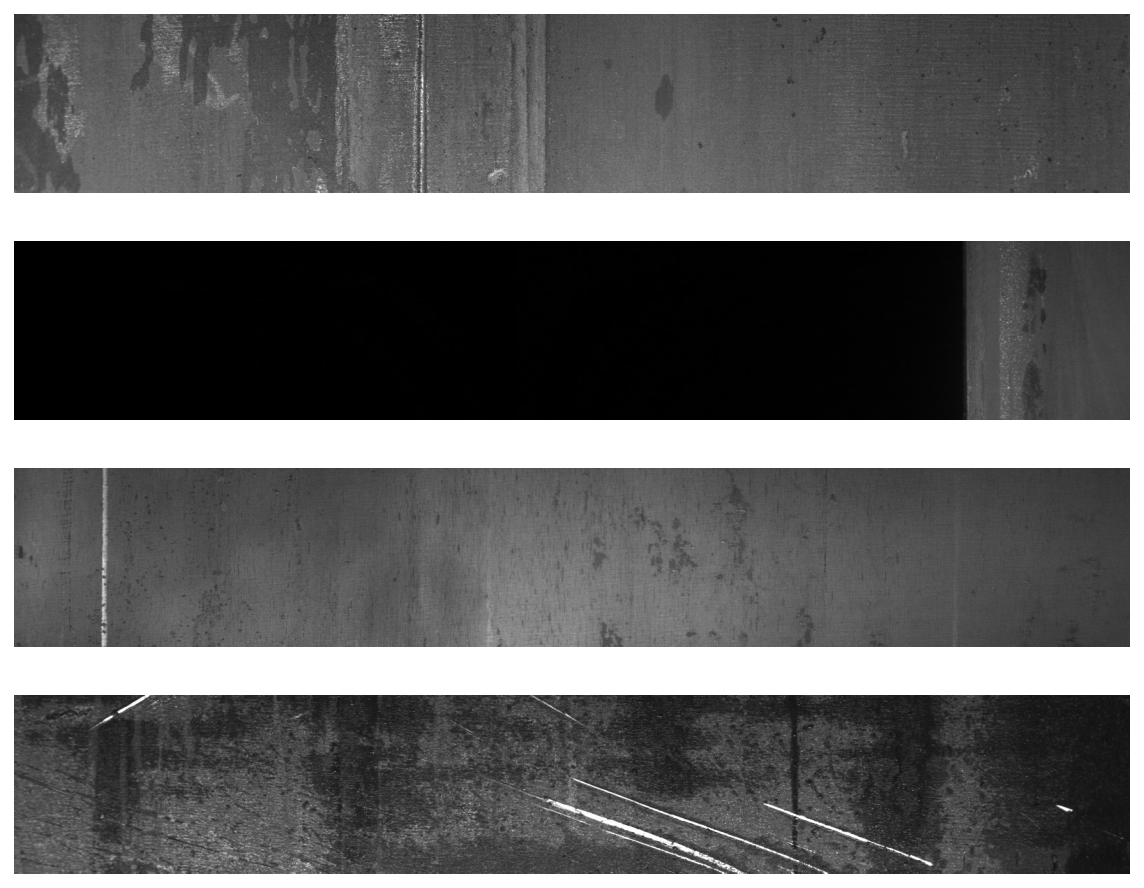

In [6]:
# Plot a random sample of images:

# Prerequisite work:
image_1 = Image.open('../data/test_images/0000f269f.jpg')
image_2 = Image.open('../data/test_images/000ccc2ac.jpg')
image_3 = Image.open('../data/test_images/002451917.jpg')
image_4 = Image.open('../data/test_images/003c5da97.jpg')

# Define the graph:
fig, axes = plt.subplots(4, figsize=(10, 8))

# Configuration of the graph:
axes[0].imshow(image_1)
axes[0].axis('off')
axes[1].imshow(image_2)
axes[1].axis('off')
axes[2].imshow(image_3)
axes[2].axis('off')
axes[3].imshow(image_4)
axes[3].axis('off')

# Save the graph:
fig.savefig('../graphs/random_sample.png', bbox_inches='tight')

We can observe that 5506 images have been provided, each one of them with the same dimensions, a width of 1600 and an height of 256.

---

## *train.csv*

We can now work on a more in-depth study, beginning with the tabular data file *train.csv*.

In [7]:
# Load the data:
train = pd.read_csv("../data/train.csv")

# Check basic info:
print("*** Some basic info:")
print("'train' has {} data points with {} variables each.".format(*train.shape))
print("'train' counts {} missing values.".format(train.isnull().sum().sum()))

# Give a look to the first lines:
print("\n*** First lines:")
display(train.head(n=10))

# Give a look to the last lines:
print("\n*** Last lines:")
display(train.tail(n=10))

*** Some basic info:
'train' has 7095 data points with 3 variables each.
'train' counts 0 missing values.

*** First lines:


ImageId  ClassId                                      EncodedPixels
0  0002cc93b.jpg        1  29102 12 29346 24 29602 24 29858 24 30114 24 3...
1  0007a71bf.jpg        3  18661 28 18863 82 19091 110 19347 110 19603 11...
2  000a4bcdd.jpg        1  37607 3 37858 8 38108 14 38359 20 38610 25 388...
3  000f6bf48.jpg        4  131973 1 132228 4 132483 6 132738 8 132993 11 ...
4  0014fce06.jpg        3  229501 11 229741 33 229981 55 230221 77 230468...
5  0025bde0c.jpg        3  8458 14 8707 35 8963 48 9219 71 9475 88 9731 8...
6  0025bde0c.jpg        4  315139 8 315395 15 315651 16 315906 17 316162 ...
7  002af848d.jpg        4  290800 6 291055 13 291311 15 291566 18 291822 ...
8  002fc4e19.jpg        1  146021 3 146275 10 146529 40 146783 46 147038 ...
9  002fc4e19.jpg        2  145658 7 145901 20 146144 33 146386 47 146629 ...


*** Last lines:


ImageId  ClassId  \
7085  ff9923932.jpg        3   
7086  ff9d46e95.jpg        4   
7087  ffb48ee43.jpg        3   
7088  ffbd081d5.jpg        3   
7089  ffc9fdf70.jpg        3   
7090  ffcf72ecf.jpg        3   
7091  fff02e9c5.jpg        3   
7092  fffe98443.jpg        3   
7093  ffff4eaa8.jpg        3   
7094  ffffd67df.jpg        3   

                                          EncodedPixels  
7085  352770 158 353026 180 353282 192 353538 187 35...  
7086  326401 4 326658 9 326915 12 327172 13 327429 1...  
7087  38657 43 38913 128 39169 213 39425 2303 41751 ...  
7088  280587 11 280841 33 281095 55 281350 76 281604...  
7089  306787 4 307025 2 307041 6 307099 4 307280 5 3...  
7090  121911 34 122167 101 122422 169 122678 203 122...  
7091  207523 3 207777 9 208030 15 208283 22 208537 2...  
7092  105929 5 106177 14 106424 24 106672 33 106923 ...  
7093  16899 7 17155 20 17411 34 17667 47 17923 60 18...  
7094  30931 43 31103 127 31275 211 31489 253 31745 2...

Let's perform some additional checks.

In [8]:
# Determine unique values by columns:
train_cols = []
for col in train.columns:
    train_cols.append(col)
print("*** Additional checks:")
for col in train_cols:
    print("- Column '{}' counts {} possible values".format(col, len(train[col].unique().tolist())))
print("\n*** Column 'ClassId' has the following possible values: {}.".format(sorted(train['ClassId'].unique().tolist())))

*** Additional checks:
- Column 'ImageId' counts 6666 possible values
- Column 'ClassId' counts 4 possible values
- Column 'EncodedPixels' counts 7095 possible values

*** Column 'ClassId' has the following possible values: [1, 2, 3, 4].


We can observe that in the train dataset, it exists occurrences for all the 4 possible defect types, and that we can count 6666 images with at least 1 defect.

Let's visualize some other observations.

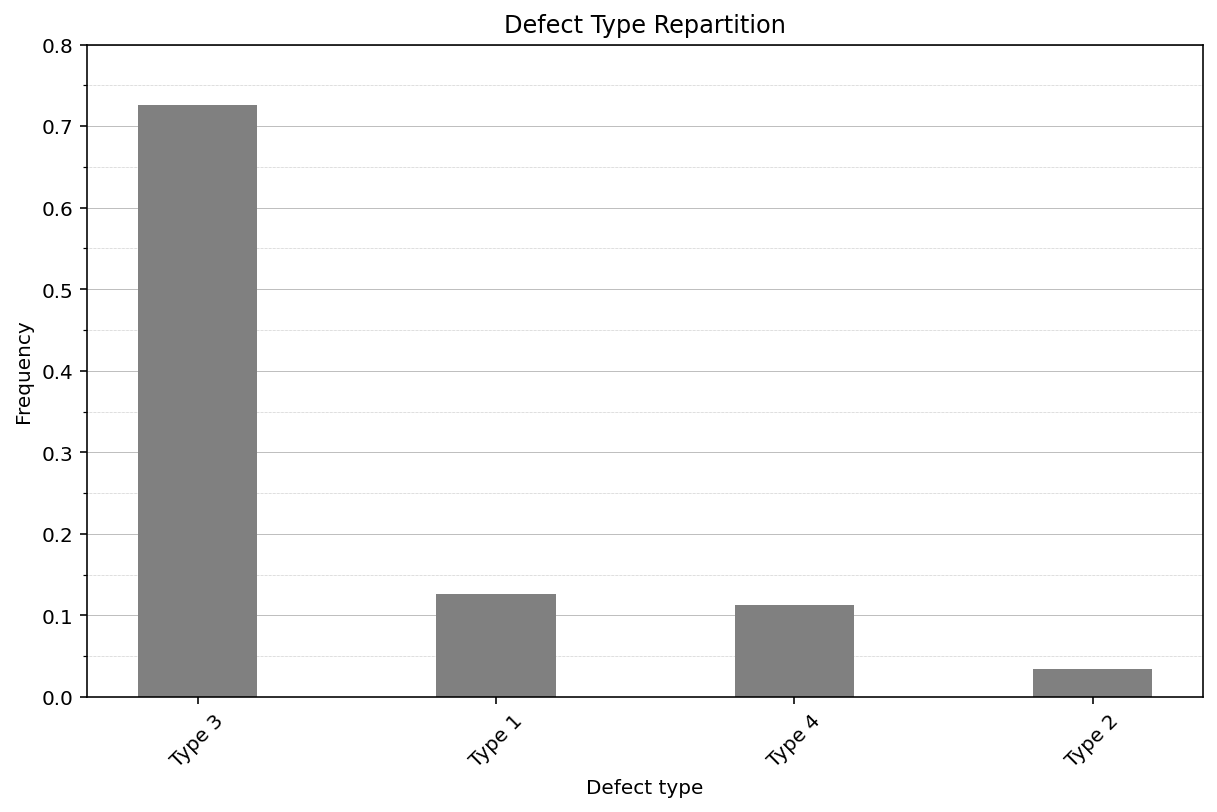

In [9]:
# Defect type repartition:

# Set abscissa and ordinate values:
defect_type = train['ClassId']
defect_type_dict = {1: 'Type 1',
                    2: 'Type 2',
                    3: 'Type 3',
                    4: 'Type 4'}
defect_type_list = [defect_type_dict[x] for x in defect_type.value_counts().index.tolist()]
defect_type_frequency = [float(x)/defect_type.value_counts().sum() for x in defect_type.value_counts().tolist()]

# Define figure:
fig, ax = plt.subplots(figsize=(10, 6))
x_values = np.arange(4)
width_rec = 0.4

# Configuration of the graph:
ax.set_title("Defect Type Repartition")
ax.bar(x_values,
       defect_type_frequency,
       width=width_rec,
       color='gray')
ax.set_xticks(x_values)
ax.set_xticklabels(defect_type_list, rotation=45)
ax.set_xlabel("Defect type")
ax.set_ylim(0, 0.8)
ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(9))
ax.yaxis.set_minor_locator(mpl.ticker.MaxNLocator(18))
ax.set_ylabel("Frequency")
ax.grid(color='grey', which='major', axis='y', linestyle='-', linewidth=0.25)
ax.grid(color='grey', which='minor', axis='y', linestyle=':', linewidth=0.25)

# Save the graph:
fig.savefig('../graphs/defect_type_repartition.png', bbox_inches='tight')

In [10]:
# Provide complete defect type repartition:
print("*** Complete defect type repartition:")
for i in range(4):
    print("- Class '{}' has a prevalence of {:.2f}%".format(defect_type_list[i], defect_type_frequency[i]*100))

*** Complete defect type repartition:
- Class 'Type 3' has a prevalence of 72.59%
- Class 'Type 1' has a prevalence of 12.64%
- Class 'Type 4' has a prevalence of 11.29%
- Class 'Type 2' has a prevalence of 3.48%


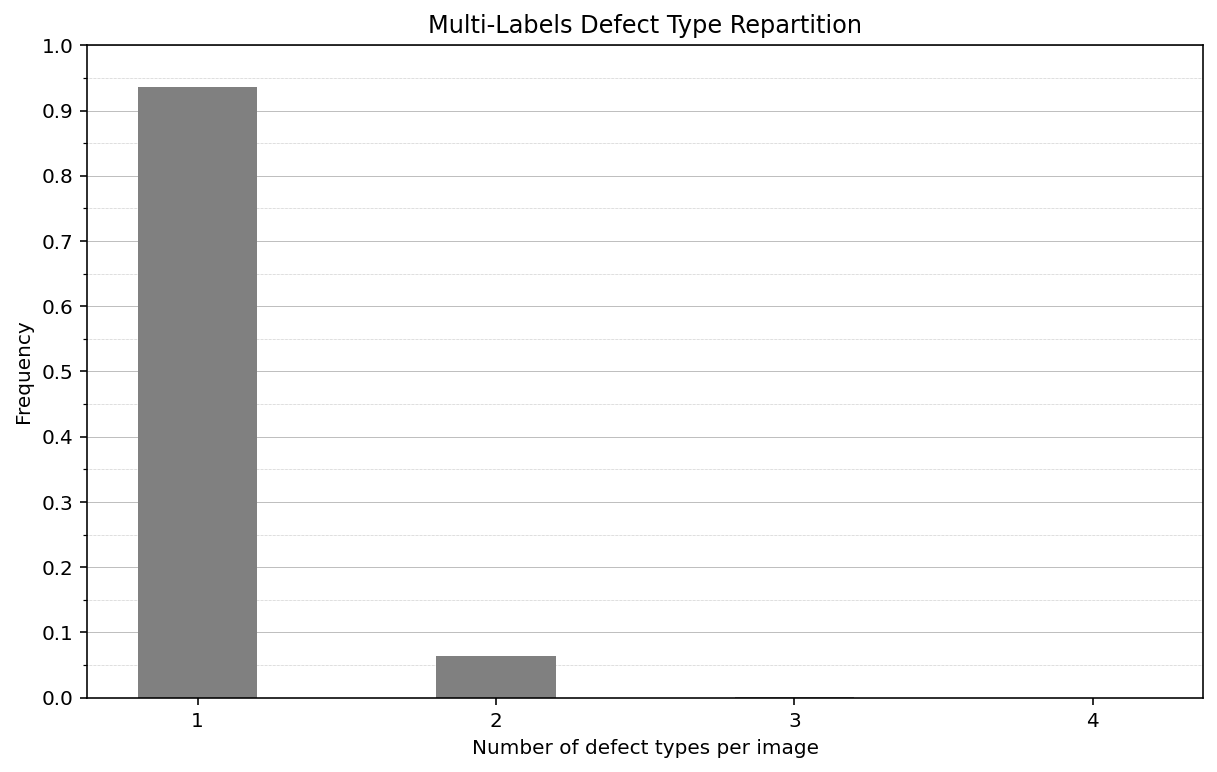

In [11]:
# Multi-labels defect type repartition:

# Prerequisite work:
multi_labels_defect_type = train.groupby('ImageId')['ImageId'].count()
multi_labels_defect_type_count = []
for i in range(1, 5):
    multi_labels_defect_type_count.append(multi_labels_defect_type[multi_labels_defect_type==i].count())
multi_labels_defect_type_list = ['1', '2', '3', '4']
multi_labels_defect_type_freq = [float(x)/sum(multi_labels_defect_type_count) for x in multi_labels_defect_type_count]

# Define figure:
fig, ax = plt.subplots(figsize=(10, 6))
x_values = np.arange(4)
width_rec = 0.4

# Configuration of the graph:
ax.set_title("Multi-Labels Defect Type Repartition")
ax.bar(x_values,
       multi_labels_defect_type_freq,
       width=width_rec,
       color='gray')
ax.set_xticks(x_values)
ax.set_xticklabels(multi_labels_defect_type_list)
ax.set_xlabel("Number of defect types per image")
ax.set_ylim(0, 1)
ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(11))
ax.yaxis.set_minor_locator(mpl.ticker.MaxNLocator(22))
ax.set_ylabel("Frequency")
ax.grid(color='grey', which='major', axis='y', linestyle='-', linewidth=0.25)
ax.grid(color='grey', which='minor', axis='y', linestyle=':', linewidth=0.25)

# Save the graph:
fig.savefig('../graphs/multi_labels_defect_type_repartition.png', bbox_inches='tight')

In [12]:
# Provide complete multi-labels defect type repartition:
print("*** Complete multi-labels defect type repartition:")
for i in range(4):
    print("- Number of defect types per image: {}, frequency: {:.2f}%".format(multi_labels_defect_type_list[i],
                                                                              multi_labels_defect_type_freq[i]*100))

*** Complete multi-labels defect type repartition:
- Number of defect types per image: 1, frequency: 93.59%
- Number of defect types per image: 2, frequency: 6.38%
- Number of defect types per image: 3, frequency: 0.03%
- Number of defect types per image: 4, frequency: 0.00%


In the analysis below, we have been able to observe that the dataset at our disposal is clearly imbalanced, and that for a very significant proportion, the images only contain one defect type.

---

## *train_images*

Here, we are going to terminate this notebook's study with the folder *train_images*.

In [13]:
# Determine number of images in the folder:
print("*** Number of images in the folder:")
!find ../data/train_images -type f -name '*.jpg'  | wc -l

*** Number of images in the folder:
   12568


In [14]:
# Determine folder's images characteristics:
nb_images, width_min, width_max, height_min, height_max = get_folder_images_characteristics("../data/train_images/")
print("*** Folder's images characteristics:")
print("- The folder contains {} images".format(nb_images))
print("- The images' width in the folder evolves from {} to {}".format(width_min, width_max))
print("- The images' height in the folder evolves from {} to {}".format(height_min, height_max))

*** Folder's images characteristics:
- The folder contains 12568 images
- The images' width in the folder evolves from 1600 to 1600
- The images' height in the folder evolves from 256 to 256


As noted in the section dedicated to folder *test_images*, the 12568 images present in the folder *train_images* have the same dimension: 1600x256.

In [15]:
# Determine images with defect type 1:
defect_type_1 = train[train['ClassId']==1]['ImageId'].tolist()

# Determine images with defect type 2:
defect_type_2 = train[train['ClassId']==2]['ImageId'].tolist()

# Determine images with defect type 3:
defect_type_3 = train[train['ClassId']==3]['ImageId'].tolist()

# Determine images with defect type 4:
defect_type_4 = train[train['ClassId']==4]['ImageId'].tolist()

# Determine images with at least 2 or 3 defect types:
images_list = train['ImageId'].tolist()
multi_labels_2 = list(set([img for img in images_list if images_list.count(img)==2]))
multi_labels_3 = list(set([img for img in images_list if images_list.count(img)==3]))

# Print some random examples:
print("*** Random examples for different possible combinations:")
print("- {} is an image with defect type 1".format(defect_type_1[42]))
print("- {} is an image with defect type 2".format(defect_type_2[42]))
print("- {} is an image with defect type 3".format(defect_type_3[42]))
print("- {} is an image with defect type 4".format(defect_type_4[0]))
print("- {} is an image with at least 2 defect types (i.e. {})".format(multi_labels_2[0],
    train[train['ImageId']==multi_labels_2[0]].iloc[:, 1].tolist()))
print("- {} is an image with at least 3 defect types (i.e. {})".format(multi_labels_3[0],
    train[train['ImageId']==multi_labels_3[0]].iloc[:, 1].tolist()))

*** Random examples for different possible combinations:
- 0aafd7471.jpg is an image with defect type 1
- 206c8bb0c.jpg is an image with defect type 2
- 02291e913.jpg is an image with defect type 3
- 000f6bf48.jpg is an image with defect type 4
- c62ca3c1f.jpg is an image with at least 2 defect types (i.e. [1, 3])
- db4867ee8.jpg is an image with at least 3 defect types (i.e. [1, 2, 3])


We can continue performing some visualizations on the random examples exposed above for different possible combinations.

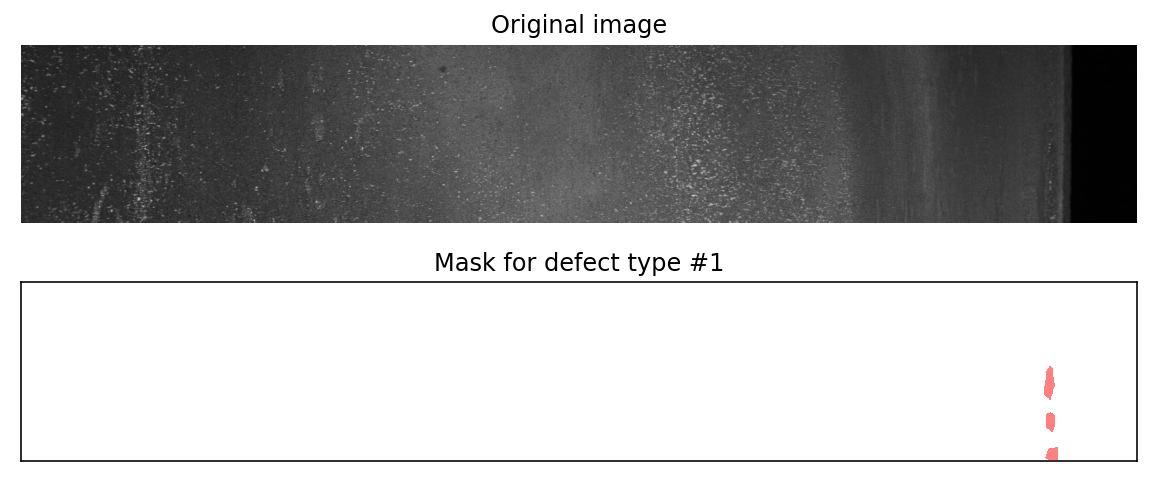

In [16]:
# Example for defect type 1:

# Prerequisite work:
img_defect_type_1 = Image.open('../data/train_images/0aafd7471.jpg')
rle_type_1 = train[(train['ImageId']=='0aafd7471.jpg') & (train['ClassId']==1)]['EncodedPixels'].values[0]
mask_type_1 = rle_to_mask(rle_type_1)

# Define the graph:
fig, axes = plt.subplots(2, figsize=(10, 4))

# Configuration of the graph:
axes[0].set_title("Original image")
axes[0].imshow(img_defect_type_1)
axes[0].axis('off')
axes[1].set_title("Mask for defect type #1")
axes[1].imshow(mask_type_1, alpha=0.5, cmap=mpl.colors.ListedColormap(['white', 'red']))
axes[1].axes.xaxis.set_visible(False)
axes[1].axes.yaxis.set_visible(False)

# Save the graph:
fig.savefig('../graphs/defect_type_1_illustration.png', bbox_inches='tight')

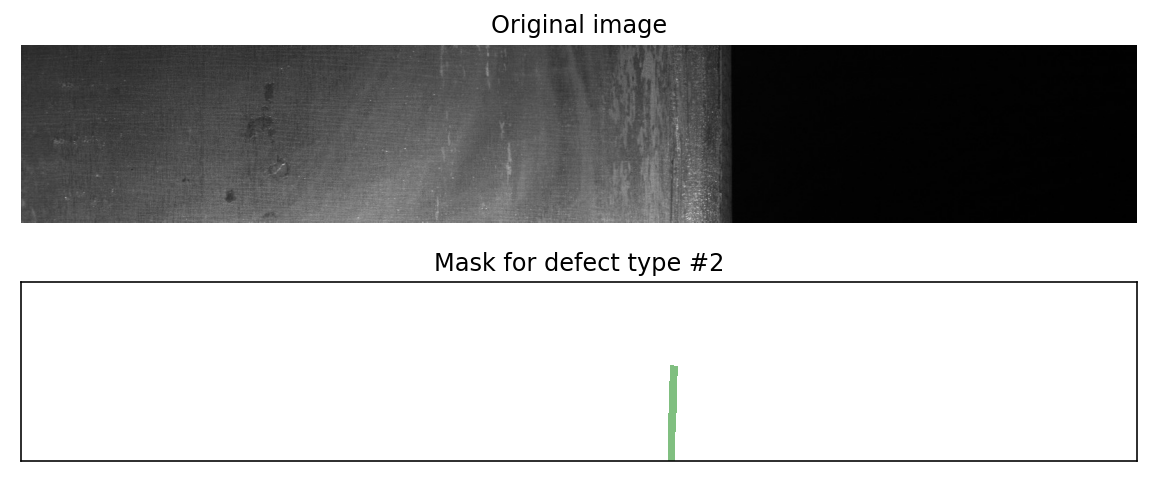

In [17]:
# Example for defect type 2:

# Prerequisite work:
img_defect_type_2 = Image.open('../data/train_images/206c8bb0c.jpg')
rle_type_2 = train[(train['ImageId']=='206c8bb0c.jpg') & (train['ClassId']==2)]['EncodedPixels'].values[0]
mask_type_2 = rle_to_mask(rle_type_2)

# Define the graph:
fig, axes = plt.subplots(2, figsize=(10, 4))

# Configuration of the graph:
axes[0].set_title("Original image")
axes[0].imshow(img_defect_type_2)
axes[0].axis('off')
axes[1].set_title("Mask for defect type #2")
axes[1].imshow(mask_type_2, alpha=0.5, cmap=mpl.colors.ListedColormap(['white', 'green']))
axes[1].axes.xaxis.set_visible(False)
axes[1].axes.yaxis.set_visible(False)

# Save the graph:
fig.savefig('../graphs/defect_type_2_illustration.png', bbox_inches='tight')

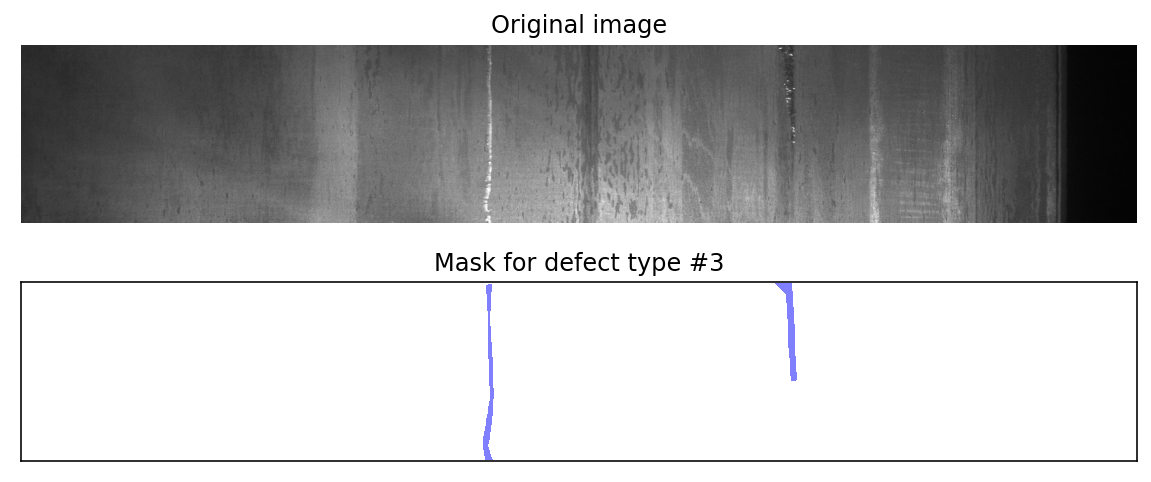

In [18]:
# Example for defect type 3:

# Prerequisite work:
img_defect_type_3 = Image.open('../data/train_images/02291e913.jpg')
rle_type_3 = train[(train['ImageId']=='02291e913.jpg') & (train['ClassId']==3)]['EncodedPixels'].values[0]
mask_type_3 = rle_to_mask(rle_type_3)

# Define the graph:
fig, axes = plt.subplots(2, figsize=(10, 4))

# Configuration of the graph:
axes[0].set_title("Original image")
axes[0].imshow(img_defect_type_3)
axes[0].axis('off')
axes[1].set_title("Mask for defect type #3")
axes[1].imshow(mask_type_3, alpha=0.5, cmap=mpl.colors.ListedColormap(['white', 'blue']))
axes[1].axes.xaxis.set_visible(False)
axes[1].axes.yaxis.set_visible(False)

# Save the graph:
fig.savefig('../graphs/defect_type_3_illustration.png', bbox_inches='tight')

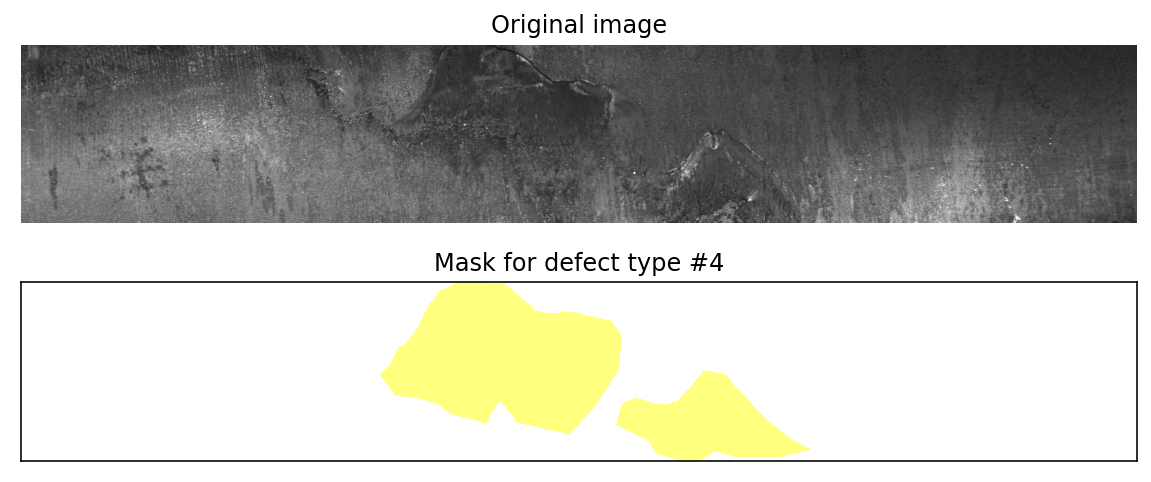

In [19]:
# Example for defect type 4:

# Prerequisite work:
img_defect_type_4 = Image.open('../data/train_images/000f6bf48.jpg')
rle_type_4 = train[(train['ImageId']=='000f6bf48.jpg') & (train['ClassId']==4)]['EncodedPixels'].values[0]
mask_type_4 = rle_to_mask(rle_type_4)

# Define the graph:
fig, axes = plt.subplots(2, figsize=(10, 4))

# Configuration of the graph:
axes[0].set_title("Original image")
axes[0].imshow(img_defect_type_4)
axes[0].axis('off')
axes[1].set_title("Mask for defect type #4")
axes[1].imshow(mask_type_4, alpha=0.5, cmap=mpl.colors.ListedColormap(['white', 'yellow']))
axes[1].axes.xaxis.set_visible(False)
axes[1].axes.yaxis.set_visible(False)

# Save the graph:
fig.savefig('../graphs/defect_type_4_illustration.png', bbox_inches='tight')

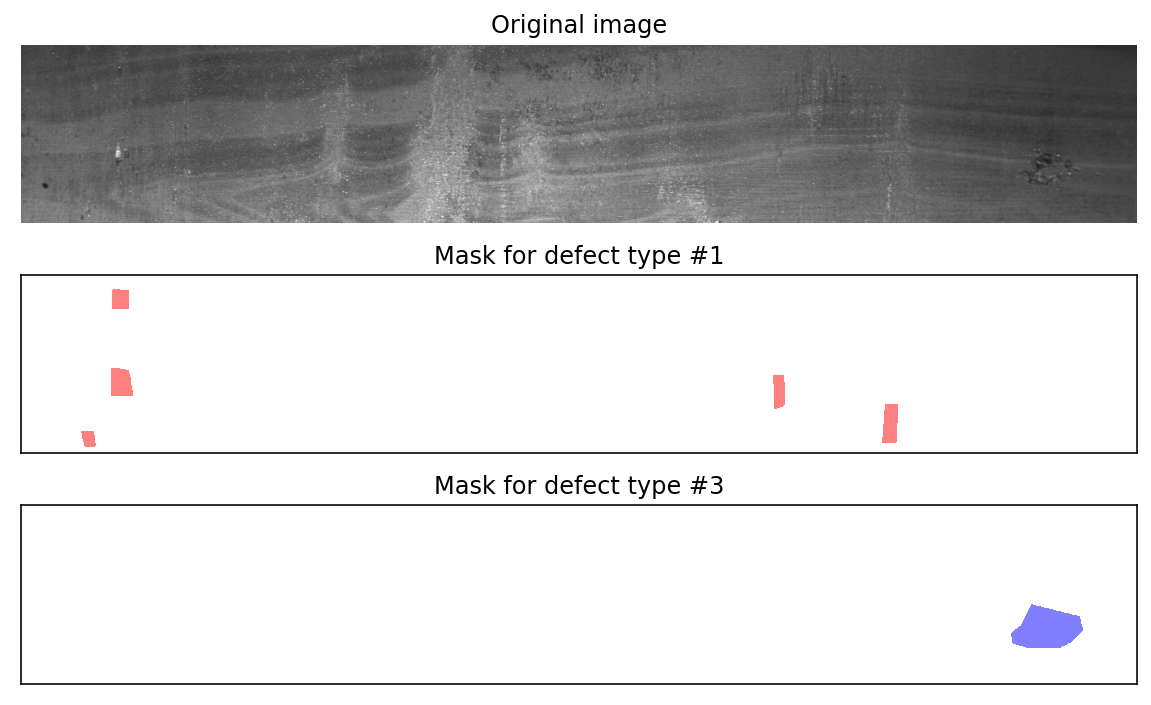

In [20]:
# Example for two different defect types:

# Prerequisite work:
img_multi_labels_2 = Image.open('../data/train_images/c62ca3c1f.jpg')
rle_type_1 = train[(train['ImageId']=='c62ca3c1f.jpg') & (train['ClassId']==1)]['EncodedPixels'].values[0]
mask_type_1 = rle_to_mask(rle_type_1)
rle_type_3 = train[(train['ImageId']=='c62ca3c1f.jpg') & (train['ClassId']==3)]['EncodedPixels'].values[0]
mask_type_3 = rle_to_mask(rle_type_3)

# Define the graph:
fig, axes = plt.subplots(3, figsize=(10, 6))

# Configuration of the graph:
axes[0].set_title("Original image")
axes[0].imshow(img_multi_labels_2)
axes[0].axis('off')
axes[1].set_title("Mask for defect type #1")
axes[1].imshow(mask_type_1, alpha=0.5, cmap=mpl.colors.ListedColormap(['white', 'red']))
axes[1].axes.xaxis.set_visible(False)
axes[1].axes.yaxis.set_visible(False)
axes[2].set_title("Mask for defect type #3")
axes[2].imshow(mask_type_3, alpha=0.5, cmap=mpl.colors.ListedColormap(['white', 'blue']))
axes[2].axes.xaxis.set_visible(False)
axes[2].axes.yaxis.set_visible(False)

# Save the graph:
fig.savefig('../graphs/multi_labels_2_illustration.png', bbox_inches='tight')

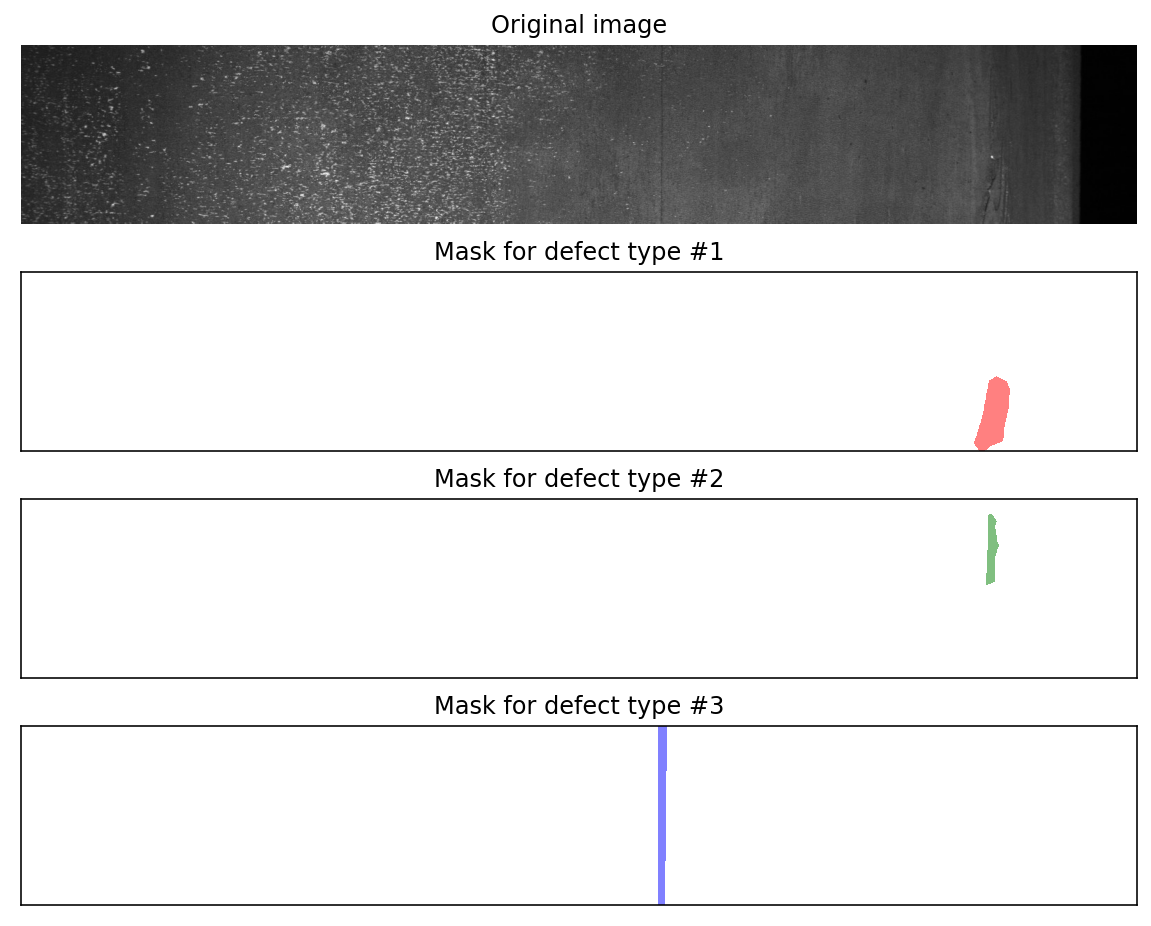

In [21]:
# Example for three different defect types:

# Prerequisite work:
img_multi_labels_3 = Image.open('../data/train_images/db4867ee8.jpg')
rle_type_1 = train[(train['ImageId']=='db4867ee8.jpg') & (train['ClassId']==1)]['EncodedPixels'].values[0]
mask_type_1 = rle_to_mask(rle_type_1)
rle_type_2 = train[(train['ImageId']=='db4867ee8.jpg') & (train['ClassId']==2)]['EncodedPixels'].values[0]
mask_type_2 = rle_to_mask(rle_type_2)
rle_type_3 = train[(train['ImageId']=='db4867ee8.jpg') & (train['ClassId']==3)]['EncodedPixels'].values[0]
mask_type_3 = rle_to_mask(rle_type_3)

# Define the graph:
fig, axes = plt.subplots(4, figsize=(10, 8))

# Configuration of the graph:
axes[0].set_title("Original image")
axes[0].imshow(img_multi_labels_3)
axes[0].axis('off')
axes[1].set_title("Mask for defect type #1")
axes[1].imshow(mask_type_1, alpha=0.5, cmap=mpl.colors.ListedColormap(['white', 'red']))
axes[1].axes.xaxis.set_visible(False)
axes[1].axes.yaxis.set_visible(False)
axes[2].set_title("Mask for defect type #2")
axes[2].imshow(mask_type_2, alpha=0.5, cmap=mpl.colors.ListedColormap(['white', 'green']))
axes[2].axes.xaxis.set_visible(False)
axes[2].axes.yaxis.set_visible(False)
axes[3].set_title("Mask for defect type #3")
axes[3].imshow(mask_type_3, alpha=0.5, cmap=mpl.colors.ListedColormap(['white', 'blue']))
axes[3].axes.xaxis.set_visible(False)
axes[3].axes.yaxis.set_visible(False)

# Save the graph:
fig.savefig('../graphs/multi_labels_3_illustration.png', bbox_inches='tight')

Finally, we can terminate this study determining and visualizing some other stats about the number of defects per image.

In [22]:
# Enhance training dataframe:
train_enhanced = calculate_nb_defects_in_mask(train)

# Determine mean number of defects per image:
mean_nb_defects_img = train_enhanced.groupby('ImageId')['NbDefects'].sum().mean()

# Determine mean number of defects by type when present:
train_enhanced_2 = train_enhanced.groupby('ClassId')['NbDefects'].mean()

# Print results:
print("*** Some stats on defects per image:")
print("- Mean number of defects per image: {:.2f}".format(mean_nb_defects_img))
print("- Mean number of type 1 defects (when present) per image: {:.2f}".format(train_enhanced_2.tolist()[0]))
print("- Mean number of type 2 defects (when present) per image: {:.2f}".format(train_enhanced_2.tolist()[1]))
print("- Mean number of type 3 defects (when present) per image: {:.2f}".format(train_enhanced_2.tolist()[2]))
print("- Mean number of type 4 defects (when present) per image: {:.2f}".format(train_enhanced_2.tolist()[3]))

/Users/mrksinant/Documents/miniconda3/envs/Severstal/lib/python3.8/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


*** Some stats on defects per image:
- Mean number of defects per image: 2.99
- Mean number of type 1 defects (when present) per image: 3.44
- Mean number of type 2 defects (when present) per image: 1.30
- Mean number of type 3 defects (when present) per image: 2.84
- Mean number of type 4 defects (when present) per image: 2.38


In [23]:
# Image with maximum number of type 1 defects:
max_t1_defects = train_enhanced[(train_enhanced['ClassId']==1)]['NbDefects'].max()
max_t1_defects_img = train_enhanced[(train_enhanced['ClassId']==1)&(train_enhanced['NbDefects']==max_t1_defects)]['ImageId'].tolist()[0]

# Image with maximum number of type 2 defects:
max_t2_defects = train_enhanced[(train_enhanced['ClassId']==2)]['NbDefects'].max()
max_t2_defects_img = train_enhanced[(train_enhanced['ClassId']==2)&(train_enhanced['NbDefects']==max_t2_defects)]['ImageId'].tolist()[0]

# Image with maximum number of type 3 defects:
max_t3_defects = train_enhanced[(train_enhanced['ClassId']==3)]['NbDefects'].max()
max_t3_defects_img = train_enhanced[(train_enhanced['ClassId']==3)&(train_enhanced['NbDefects']==max_t3_defects)]['ImageId'].tolist()[0]

# Image with maximum number of type 4 defects:
max_t4_defects = train_enhanced[(train_enhanced['ClassId']==4)]['NbDefects'].max()
max_t4_defects_img = train_enhanced[(train_enhanced['ClassId']==4)&(train_enhanced['NbDefects']==max_t4_defects)]['ImageId'].tolist()[0]

# Print results:
print("*** Some other stats on defects per image:")
print("- Image {} counts the maximum of type 1 defects: {}".format(max_t1_defects_img, max_t1_defects))
print("- Image {} counts the maximum of type 2 defects: {}".format(max_t2_defects_img, max_t2_defects))
print("- Image {} counts the maximum of type 3 defects: {}".format(max_t3_defects_img, max_t3_defects))
print("- Image {} counts the maximum of type 4 defects: {}".format(max_t4_defects_img, max_t4_defects))

*** Some other stats on defects per image:
- Image ff001adfe.jpg counts the maximum of type 1 defects: 20
- Image 5238bc100.jpg counts the maximum of type 2 defects: 4
- Image b68a9259a.jpg counts the maximum of type 3 defects: 19
- Image d169e1b81.jpg counts the maximum of type 4 defects: 14


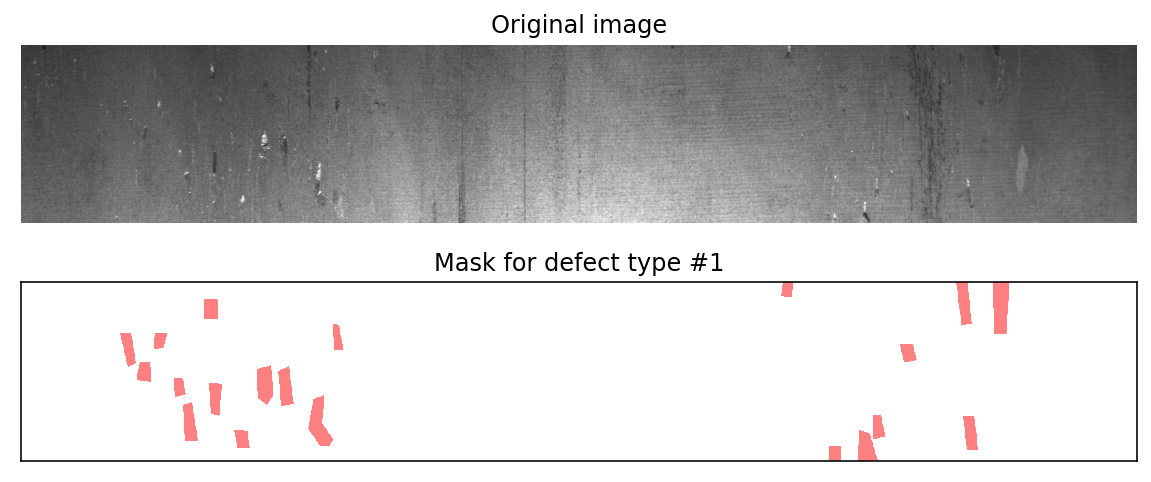

In [24]:
# Example for defect type 1:

# Prerequisite work:
img_defect_type_1 = Image.open('../data/train_images/ff001adfe.jpg')
rle_type_1 = train[(train['ImageId']=='ff001adfe.jpg') & (train['ClassId']==1)]['EncodedPixels'].values[0]
mask_type_1 = rle_to_mask(rle_type_1)

# Define the graph:
fig, axes = plt.subplots(2, figsize=(10, 4))

# Configuration of the graph:
axes[0].set_title("Original image")
axes[0].imshow(img_defect_type_1)
axes[0].axis('off')
axes[1].set_title("Mask for defect type #1")
axes[1].imshow(mask_type_1, alpha=0.5, cmap=mpl.colors.ListedColormap(['white', 'red']))
axes[1].axes.xaxis.set_visible(False)
axes[1].axes.yaxis.set_visible(False)

# Save the graph:
fig.savefig('../graphs/defect_type_1_illustration_bis.png', bbox_inches='tight')

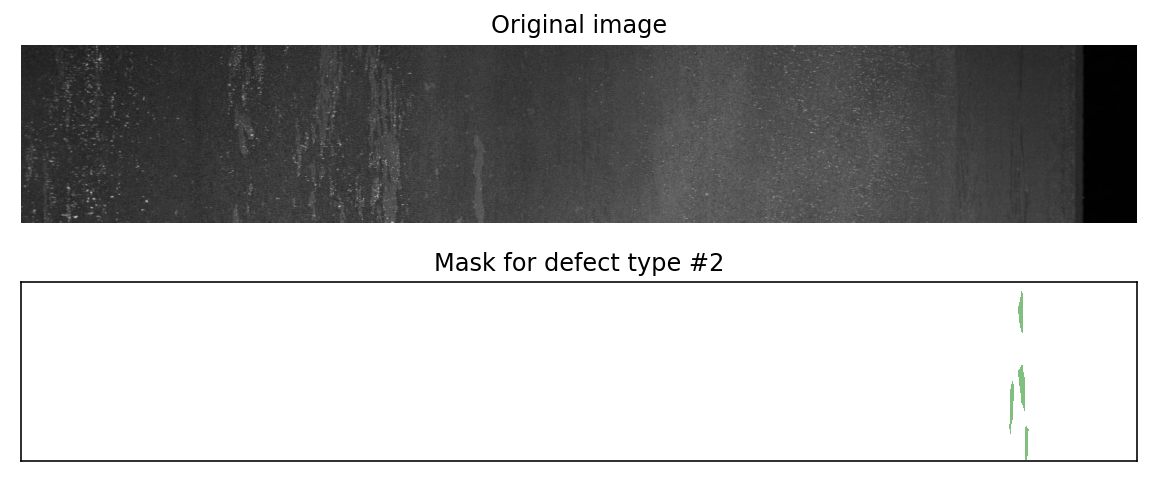

In [25]:
# Example for defect type 2:

# Prerequisite work:
img_defect_type_2 = Image.open('../data/train_images/5238bc100.jpg')
rle_type_2 = train[(train['ImageId']=='5238bc100.jpg') & (train['ClassId']==2)]['EncodedPixels'].values[0]
mask_type_2 = rle_to_mask(rle_type_2)

# Define the graph:
fig, axes = plt.subplots(2, figsize=(10, 4))

# Configuration of the graph:
axes[0].set_title("Original image")
axes[0].imshow(img_defect_type_2)
axes[0].axis('off')
axes[1].set_title("Mask for defect type #2")
axes[1].imshow(mask_type_2, alpha=0.5, cmap=mpl.colors.ListedColormap(['white', 'green']))
axes[1].axes.xaxis.set_visible(False)
axes[1].axes.yaxis.set_visible(False)

# Save the graph:
fig.savefig('../graphs/defect_type_2_illustration_bis.png', bbox_inches='tight')

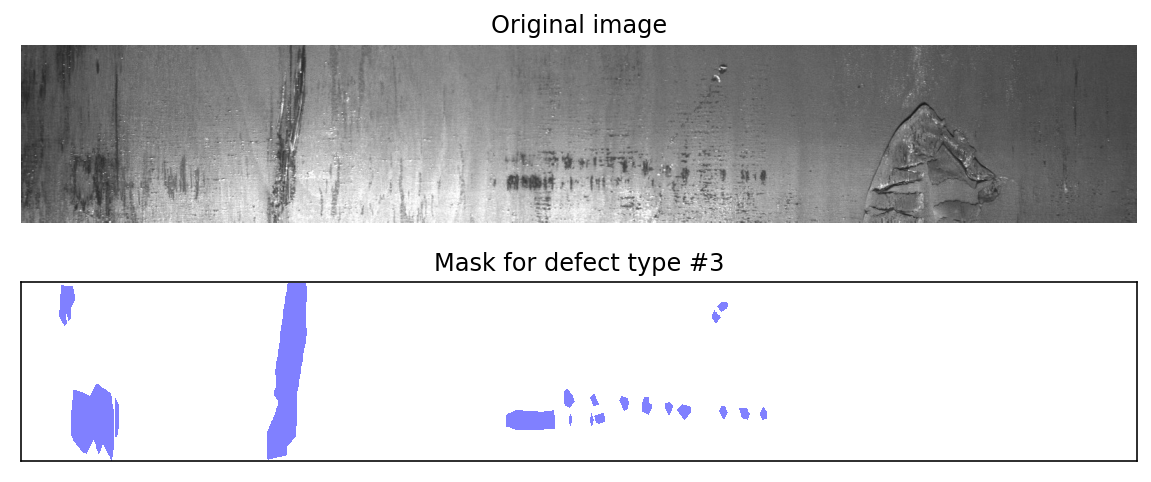

In [26]:
# Example for defect type 3:

# Prerequisite work:
img_defect_type_3 = Image.open('../data/train_images/b68a9259a.jpg')
rle_type_3 = train[(train['ImageId']=='b68a9259a.jpg') & (train['ClassId']==3)]['EncodedPixels'].values[0]
mask_type_3 = rle_to_mask(rle_type_3)

# Define the graph:
fig, axes = plt.subplots(2, figsize=(10, 4))

# Configuration of the graph:
axes[0].set_title("Original image")
axes[0].imshow(img_defect_type_3)
axes[0].axis('off')
axes[1].set_title("Mask for defect type #3")
axes[1].imshow(mask_type_3, alpha=0.5, cmap=mpl.colors.ListedColormap(['white', 'blue']))
axes[1].axes.xaxis.set_visible(False)
axes[1].axes.yaxis.set_visible(False)

# Save the graph:
fig.savefig('../graphs/defect_type_3_illustration_bis.png', bbox_inches='tight')

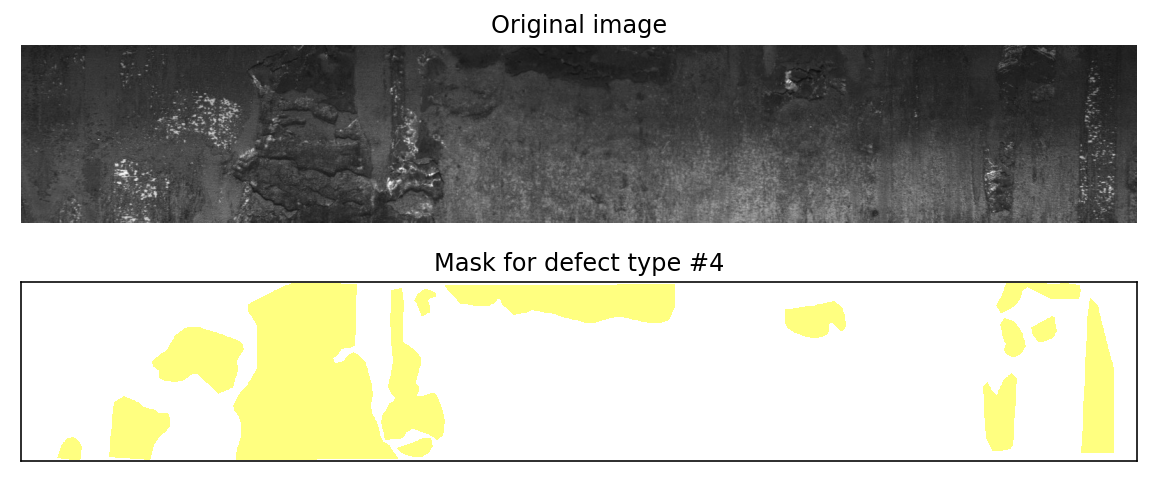

In [27]:
# Example for defect type 4:

# Prerequisite work:
img_defect_type_4 = Image.open('../data/train_images/d169e1b81.jpg')
rle_type_4 = train[(train['ImageId']=='d169e1b81.jpg') & (train['ClassId']==4)]['EncodedPixels'].values[0]
mask_type_4 = rle_to_mask(rle_type_4)

# Define the graph:
fig, axes = plt.subplots(2, figsize=(10, 4))

# Configuration of the graph:
axes[0].set_title("Original image")
axes[0].imshow(img_defect_type_4)
axes[0].axis('off')
axes[1].set_title("Mask for defect type #4")
axes[1].imshow(mask_type_4, alpha=0.5, cmap=mpl.colors.ListedColormap(['white', 'yellow']))
axes[1].axes.xaxis.set_visible(False)
axes[1].axes.yaxis.set_visible(False)

# Save the graph:
fig.savefig('../graphs/defect_type_4_illustration_bis.png', bbox_inches='tight')

As it can be observed in the illustrations above, it appears that it's a very challenging problem at an human eye level to identify defects in images and, after that, to classify them between the 4 possible classes!

Below, to conclude, a last serie of visualizations, directly on a random set of images.

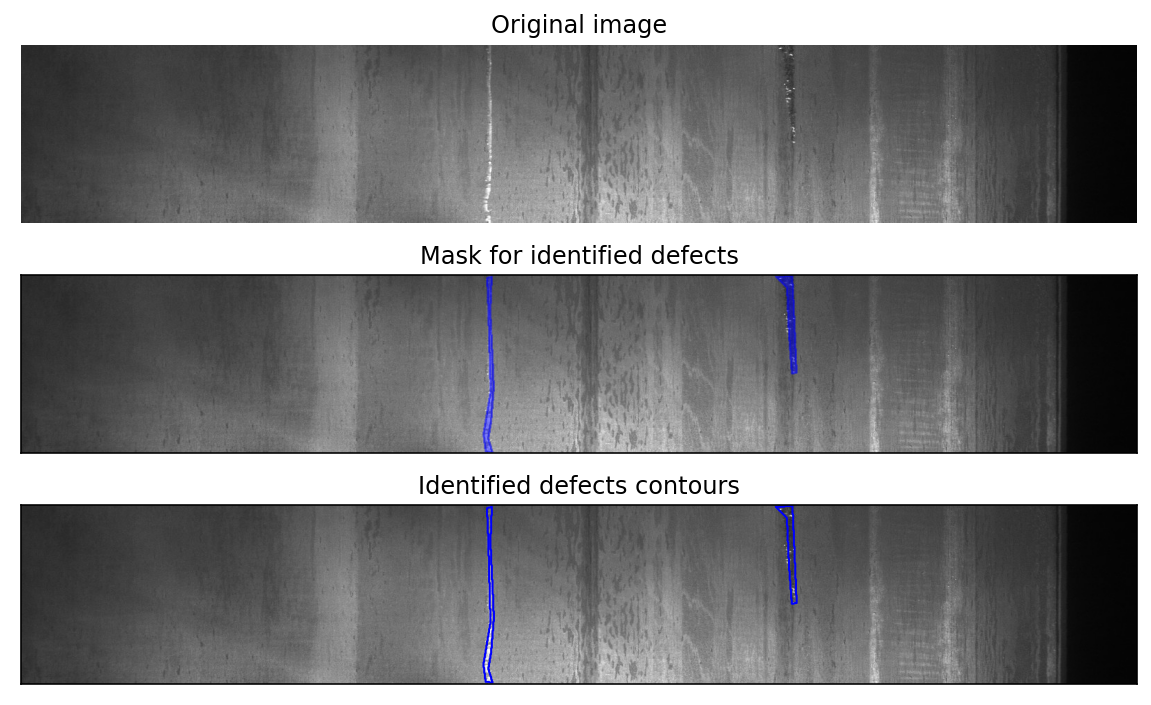

In [28]:
# Example for defect type 3:

# Prerequisite work:

# Load image:
img_random_1 = Image.open('../data/train_images/02291e913.jpg')

# Determine mask:
rle = train[(train['ImageId']=='02291e913.jpg') & (train['ClassId']==3)]['EncodedPixels'].values[0]
mask = rle_to_mask(rle)

# Determine defects in mask:
contours, _ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
patches_1 = []
patches_2 = []
for contour in contours:
    poly_patch_1 = Polygon(contour.reshape(-1, 2),
                           closed=True,
                           linewidth=1,
                           edgecolor='blue',
                           facecolor='blue',
                           fill=True)
    patches_1.append(poly_patch_1)
    poly_patch_2 = Polygon(contour.reshape(-1, 2),
                           closed=True,
                           linewidth=1,
                           edgecolor='blue',
                           fill=False)
    patches_2.append(poly_patch_2)
patch_collection_1 = PatchCollection(patches_1,
                                     match_original=True,
                                     cmap=mpl.cm.jet,
                                     alpha=0.5)
patch_collection_2 = PatchCollection(patches_2,
                                     match_original=True,
                                     cmap=mpl.cm.jet)

# Define the graph:
fig, axes = plt.subplots(3, figsize=(10, 6))

# Configuration of the graph:
axes[0].set_title("Original image")
axes[0].imshow(img_random_1)
axes[0].axis('off')
axes[1].set_title("Mask for identified defects")
axes[1].imshow(img_random_1)
axes[1].add_collection(patch_collection_1)
axes[1].axes.xaxis.set_visible(False)
axes[1].axes.yaxis.set_visible(False)
axes[2].set_title("Identified defects contours")
axes[2].imshow(img_random_1)
axes[2].add_collection(patch_collection_2)
axes[2].axes.xaxis.set_visible(False)
axes[2].axes.yaxis.set_visible(False)

# Save the graph:
fig.savefig('../graphs/mask_on_image_random_1.png', bbox_inches='tight')

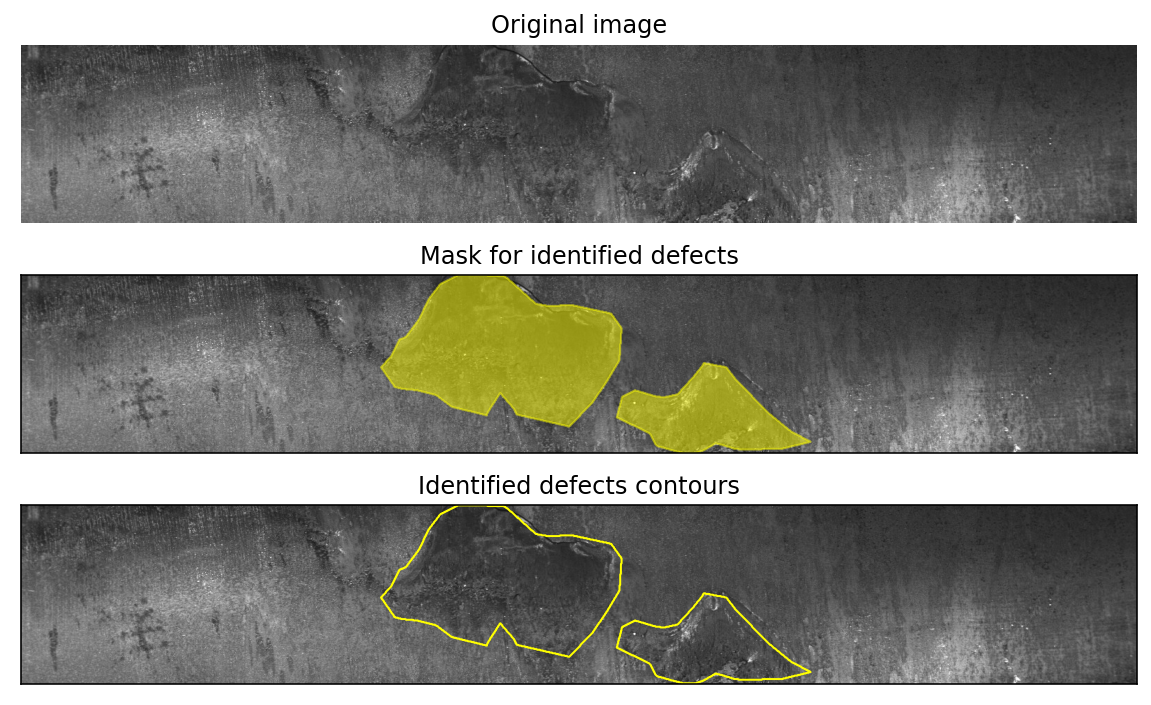

In [29]:
# Example for defect type 4:

# Prerequisite work:

# Load image:
img_random_2 = Image.open('../data/train_images/000f6bf48.jpg')

# Determine mask:
rle = train[(train['ImageId']=='000f6bf48.jpg') & (train['ClassId']==4)]['EncodedPixels'].values[0]
mask = rle_to_mask(rle)

# Determine defects in mask:
contours, _ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
patches_1 = []
patches_2 = []
for contour in contours:
    poly_patch_1 = Polygon(contour.reshape(-1, 2),
                           closed=True,
                           linewidth=1,
                           edgecolor='yellow',
                           facecolor='yellow',
                           fill=True)
    patches_1.append(poly_patch_1)
    poly_patch_2 = Polygon(contour.reshape(-1, 2),
                           closed=True,
                           linewidth=1,
                           edgecolor='yellow',
                           fill=False)
    patches_2.append(poly_patch_2)
patch_collection_1 = PatchCollection(patches_1,
                                     match_original=True,
                                     cmap=mpl.cm.jet,
                                     alpha=0.5)
patch_collection_2 = PatchCollection(patches_2,
                                     match_original=True,
                                     cmap=mpl.cm.jet)

# Define the graph:
fig, axes = plt.subplots(3, figsize=(10, 6))

# Configuration of the graph:
axes[0].set_title("Original image")
axes[0].imshow(img_random_2)
axes[0].axis('off')
axes[1].set_title("Mask for identified defects")
axes[1].imshow(img_random_2)
axes[1].add_collection(patch_collection_1)
axes[1].axes.xaxis.set_visible(False)
axes[1].axes.yaxis.set_visible(False)
axes[2].set_title("Identified defects contours")
axes[2].imshow(img_random_2)
axes[2].add_collection(patch_collection_2)
axes[2].axes.xaxis.set_visible(False)
axes[2].axes.yaxis.set_visible(False)

# Save the graph:
fig.savefig('../graphs/mask_on_image_random_2.png', bbox_inches='tight')

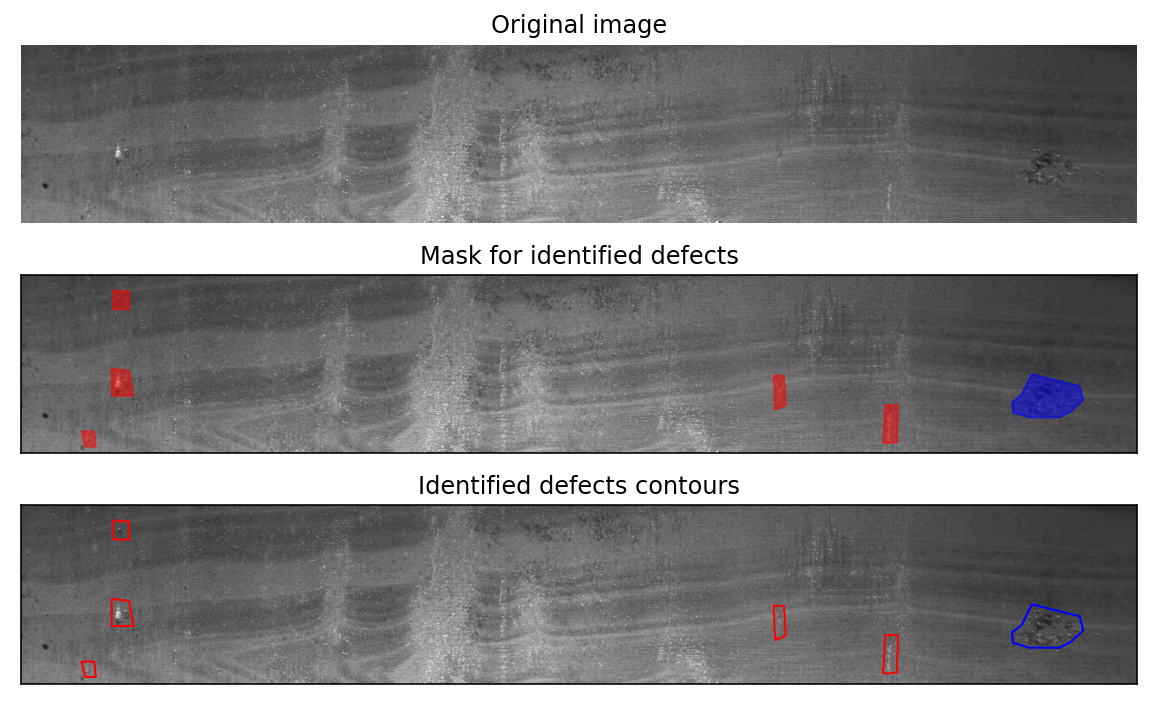

In [30]:
# Example for multi-labels defects:

# Prerequisite work:

# Load image:
img_random_3 = Image.open('../data/train_images/c62ca3c1f.jpg')

# Determine masks:
rle_1 = train[(train['ImageId']=='c62ca3c1f.jpg') & (train['ClassId']==1)]['EncodedPixels'].values[0]
mask_1 = rle_to_mask(rle_1)
rle_3 = train[(train['ImageId']=='c62ca3c1f.jpg') & (train['ClassId']==3)]['EncodedPixels'].values[0]
mask_3 = rle_to_mask(rle_3)

# Determine defects in mask:
contours, _ = cv2.findContours(mask_1, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
patches_1 = []
patches_2 = []
for contour in contours:
    poly_patch_1 = Polygon(contour.reshape(-1, 2),
                           closed=True,
                           linewidth=1,
                           edgecolor='red',
                           facecolor='red',
                           fill=True)
    patches_1.append(poly_patch_1)
    poly_patch_2 = Polygon(contour.reshape(-1, 2),
                           closed=True,
                           linewidth=1,
                           edgecolor='red',
                           fill=False)
    patches_2.append(poly_patch_2)
contours, _ = cv2.findContours(mask_3, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
for contour in contours:
    poly_patch_1 = Polygon(contour.reshape(-1, 2),
                           closed=True,
                           linewidth=1,
                           edgecolor='blue',
                           facecolor='blue',
                           fill=True)
    patches_1.append(poly_patch_1)
    poly_patch_2 = Polygon(contour.reshape(-1, 2),
                           closed=True,
                           linewidth=1,
                           edgecolor='blue',
                           fill=False)
    patches_2.append(poly_patch_2)
patch_collection_1 = PatchCollection(patches_1,
                                     match_original=True,
                                     cmap=mpl.cm.jet,
                                     alpha=0.5)
patch_collection_2 = PatchCollection(patches_2,
                                     match_original=True,
                                     cmap=mpl.cm.jet)

# Define the graph:
fig, axes = plt.subplots(3, figsize=(10, 6))

# Configuration of the graph:
axes[0].set_title("Original image")
axes[0].imshow(img_random_3)
axes[0].axis('off')
axes[1].set_title("Mask for identified defects")
axes[1].imshow(img_random_3)
axes[1].add_collection(patch_collection_1)
axes[1].axes.xaxis.set_visible(False)
axes[1].axes.yaxis.set_visible(False)
axes[2].set_title("Identified defects contours")
axes[2].imshow(img_random_3)
axes[2].add_collection(patch_collection_2)
axes[2].axes.xaxis.set_visible(False)
axes[2].axes.yaxis.set_visible(False)

# Save the graph:
fig.savefig('../graphs/mask_on_image_random_3.png', bbox_inches='tight')

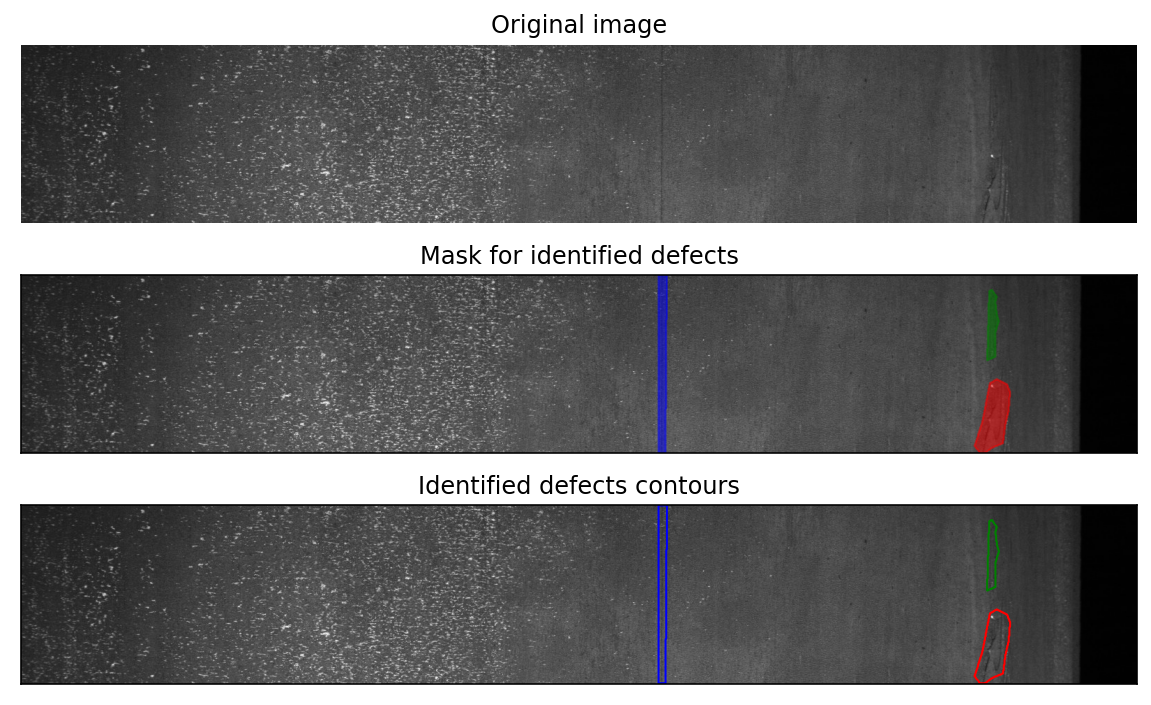

In [31]:
# Example for multi-labels defects:

# Prerequisite work:

# Load image:
img_random_4 = Image.open('../data/train_images/db4867ee8.jpg')

# Determine masks:
rle_1 = train[(train['ImageId']=='db4867ee8.jpg') & (train['ClassId']==1)]['EncodedPixels'].values[0]
mask_1 = rle_to_mask(rle_1)
rle_2 = train[(train['ImageId']=='db4867ee8.jpg') & (train['ClassId']==2)]['EncodedPixels'].values[0]
mask_2 = rle_to_mask(rle_2)
rle_3 = train[(train['ImageId']=='db4867ee8.jpg') & (train['ClassId']==3)]['EncodedPixels'].values[0]
mask_3 = rle_to_mask(rle_3)

# Determine defects in mask:
contours, _ = cv2.findContours(mask_1, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
patches_1 = []
patches_2 = []
for contour in contours:
    poly_patch_1 = Polygon(contour.reshape(-1, 2),
                           closed=True,
                           linewidth=1,
                           edgecolor='red',
                           facecolor='red',
                           fill=True)
    patches_1.append(poly_patch_1)
    poly_patch_2 = Polygon(contour.reshape(-1, 2),
                           closed=True,
                           linewidth=1,
                           edgecolor='red',
                           fill=False)
    patches_2.append(poly_patch_2)
contours, _ = cv2.findContours(mask_2, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
for contour in contours:
    poly_patch_1 = Polygon(contour.reshape(-1, 2),
                           closed=True,
                           linewidth=1,
                           edgecolor='green',
                           facecolor='green',
                           fill=True)
    patches_1.append(poly_patch_1)
    poly_patch_2 = Polygon(contour.reshape(-1, 2),
                           closed=True,
                           linewidth=1,
                           edgecolor='green',
                           fill=False)
    patches_2.append(poly_patch_2)
contours, _ = cv2.findContours(mask_3, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
for contour in contours:
    poly_patch_1 = Polygon(contour.reshape(-1, 2),
                           closed=True,
                           linewidth=1,
                           edgecolor='blue',
                           facecolor='blue',
                           fill=True)
    patches_1.append(poly_patch_1)
    poly_patch_2 = Polygon(contour.reshape(-1, 2),
                           closed=True,
                           linewidth=1,
                           edgecolor='blue',
                           fill=False)
    patches_2.append(poly_patch_2)
patch_collection_1 = PatchCollection(patches_1,
                                     match_original=True,
                                     cmap=mpl.cm.jet,
                                     alpha=0.5)
patch_collection_2 = PatchCollection(patches_2,
                                     match_original=True,
                                     cmap=mpl.cm.jet)

# Define the graph:
fig, axes = plt.subplots(3, figsize=(10, 6))

# Configuration of the graph:
axes[0].set_title("Original image")
axes[0].imshow(img_random_4)
axes[0].axis('off')
axes[1].set_title("Mask for identified defects")
axes[1].imshow(img_random_4)
axes[1].add_collection(patch_collection_1)
axes[1].axes.xaxis.set_visible(False)
axes[1].axes.yaxis.set_visible(False)
axes[2].set_title("Identified defects contours")
axes[2].imshow(img_random_4)
axes[2].add_collection(patch_collection_2)
axes[2].axes.xaxis.set_visible(False)
axes[2].axes.yaxis.set_visible(False)

# Save the graph:
fig.savefig('../graphs/mask_on_image_random_4.png', bbox_inches='tight')